# 19.1. What Is Hyperparameter Optimization

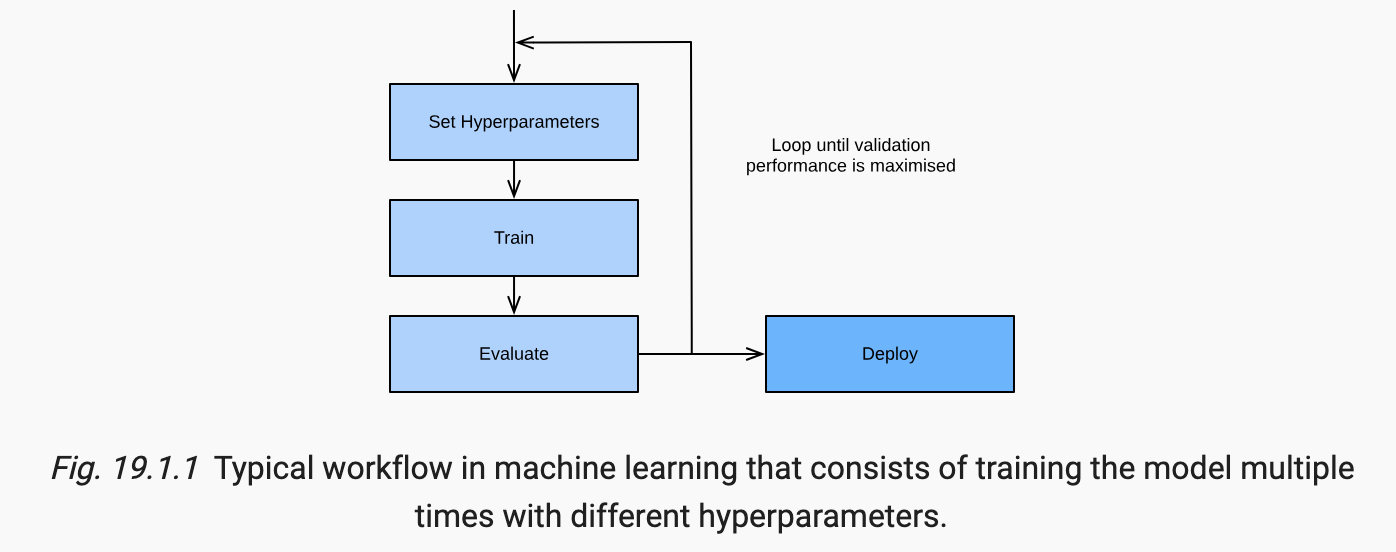

# 19.2. Hyperparameter Optimization API

# 19.3. Asynchronous Random Search

# 19.4. Multi-Fidelity Hyperparameter Optimization

# 19.5. Asynchronous Successive Halving 